In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
plt.style.use("project_style.mplstyle")
from tqdm import tqdm

import stats
import environments
import analysis_tools

In [2]:
def error_kde(errors, n, ylim, bw = None):
    kdes = np.zeros((n, errors.shape[-1]))
    eval_errs = np.linspace(0, ylim, n)
    
    for i in range(errors.shape[-1]):
        kernel = scipy.stats.gaussian_kde(errors[:,i], bw_method = bw)
        kdes[:, i] = kernel(eval_errs) 
    return kdes

def inset_walls(ax, walls, scale = 0.2):
    w = np.amax(np.abs(walls))*1.1*scale
    h = w
    subax = ax.inset_axes(bounds = [0.65, 0.65, w, h])
    print(w, h)
    for wall in walls:
        subax.plot(*walls.T, "k", linewidth = 0.25)
        subax.axis("equal")
        subax.axis("off")
    

In [3]:
path = f"../VPC_l1_10_l2_1"
model, params = analysis_tools.load_model(path, device = "cpu") # model of interest

timesteps = 20000 # timesteps per sequence
samples = 100 # of samples for each environment

In [4]:
envs = environments.Environments()
walls = envs.envs
envs = list(envs.envs) # :)

loss = np.zeros((len(envs), samples, timesteps))

In [5]:
for i, env in enumerate(tqdm(envs)):
    sequence = samples*[env] # sample environment several times
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"])
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    _, _, _, preds, _ = model.inference(dataset)
    loss[i] = np.linalg.norm(preds - r, axis = -1)

100%|████████████████████████████████████████████| 6/6 [30:08<00:00, 301.47s/it]


0.22000000000000008 0.22000000000000008
0.22000000000000003 0.22000000000000003
0.3300000000000001 0.3300000000000001
0.3300000000000001 0.3300000000000001
0.22000000000000008 0.22000000000000008
0.22000000000000008 0.22000000000000008


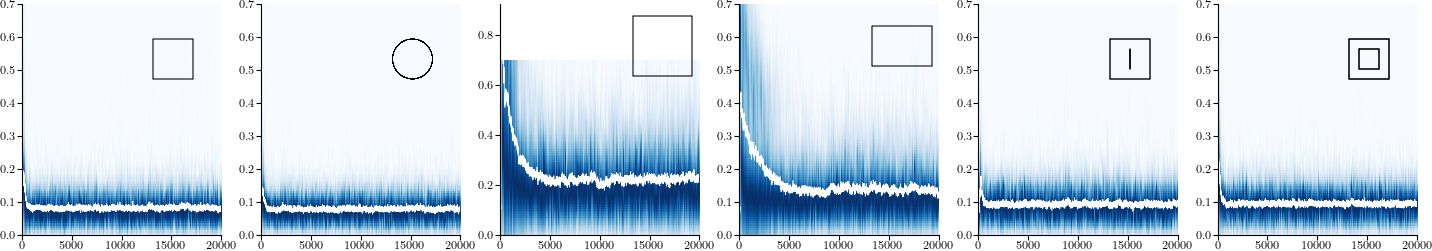

In [6]:
fig, ax = plt.subplots(1, len(envs), figsize = (18, 3))

ylim = np.amax(loss)/3

for i, current_loss in enumerate(loss):    
    kde = error_kde(current_loss, 100, ylim)
    kde = kde / np.amax(kde, axis = 0)[None]
    ax[i].imshow(kde, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim])#, vmin = 0)#, vmax = np.amax(kde))
    ax[i].plot(np.mean(current_loss, axis = 0), "-w", linewidth = 0.5)
    inset_walls(ax[i], walls[envs[i]])
    #ax[i].axis("off")


0.22000000000000008 0.22000000000000008
0.22000000000000003 0.22000000000000003
0.3300000000000001 0.3300000000000001
0.3300000000000001 0.3300000000000001
0.22000000000000008 0.22000000000000008
0.22000000000000008 0.22000000000000008


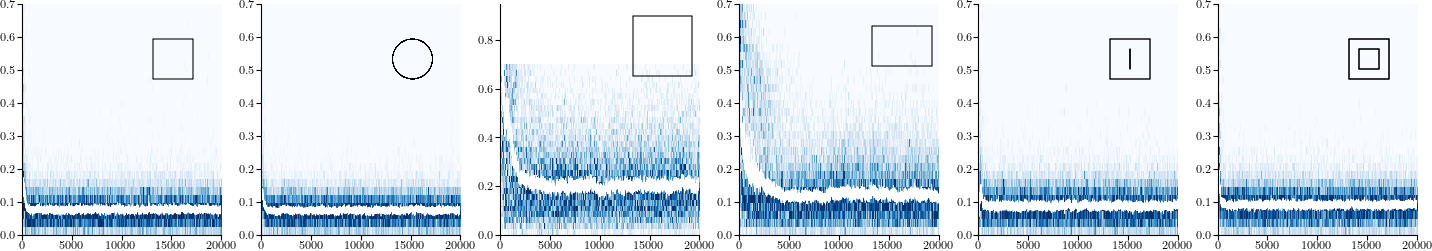

In [7]:
ny = 30
hist = np.zeros((len(envs), ny, timesteps))

fig, ax = plt.subplots(1, len(envs), figsize = (18, 3))

ybins = np.linspace(0, ylim, ny)
xbins = np.linspace(0, timesteps-1, timesteps)
timestamps = np.array([xbins for i in range(samples)])

for i, current_loss in enumerate(loss):
    #hist[i] = 0
    hist = np.histogram2d( timestamps.ravel(), current_loss.ravel(),bins = [xbins, ybins])[0]
    hist /= np.amax(hist, axis = 1, keepdims = True)
    ax[i].imshow(hist.T, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim])#, vmin = 0)#, vmax = np.amax(kde))
    ax[i].plot(np.median(current_loss, axis = 0), "-w", linewidth = 0.5)
    inset_walls(ax[i], walls[envs[i]])
